In [4]:
import numpy as np
import matplotlib.pyplot as plt
from pyTMD.time import convert_calendar_dates, datetime_to_list
from pyTMD.io import model, GOT, ATLAS
from pyTMD.predict import time_series, infer_minor, map
from datetime import datetime, timedelta

In [5]:
# Create model object
def get_tide_model(model_name, model_directory, model_format, compressed=False):
    return model(model_directory, format=model_format, compressed=compressed).elevation(model_name)

# Load and interpolate tidal constants
def get_tide_constants(lon, lat, tide_model, model_name):
    if 'GOT' in model_name:
        constituents = GOT.read_constants(tide_model.model_file, compressed=tide_model.compressed)
        amp, ph = GOT.interpolate_constants(np.array([lon]), np.array([lat]),  
                        constituents, scale=tide_model.scale, 
                        method='spline', extrapolate=True)

    elif 'atlas' in model_name:
        constituents = ATLAS.read_constants(tide_model.grid_file, tide_model.model_file, type=tide_model.type, compressed=tide_model.compressed)
        amp, ph, D = ATLAS.interpolate_constants(
                        np.atleast_1d(lon), np.atleast_1d(lat),
                        constituents, type=tide_model.type, scale=tide_model.scale,
                        method='spline', extrapolate=True)

    return constituents, amp, ph

In [6]:
# Model parameters
tpxo_model_directory = '/home/bioer/python/tide/data_src'
tpxo_model_format = 'netcdf'
tpxo_compressed = False
tpxo_model_name = 'TPXO9-atlas-v5'
tpxo9_atlas_v5 = get_tide_model(tpxo_model_name, tpxo_model_directory, tpxo_model_format, tpxo_compressed)

In [7]:
print(tpxo9_atlas_v5.grid_file)

/home/bioer/python/tide/data_src/TPXO9_atlas_v5/grid_tpxo9_atlas_30_v5.nc


In [8]:
#read_netcdf_grid in ATLAS.py
import netCDF4
fileID = netCDF4.Dataset(tpxo9_atlas_v5.grid_file, 'r')
# read latitude and longitude at z-nodes
lonz = fileID.variables['lon_z'][:].copy()
latz = fileID.variables['lat_z'][:].copy()
print(lonz)
print(latz)
print(lonz.shape)
print(latz.shape)
nx = fileID.dimensions['nx'].size
ny = fileID.dimensions['ny'].size
print(ny, nx)

[3.33333340e-02 6.66666670e-02 9.99999999e-02 ... 3.59933329e+02
 3.59966663e+02 3.59999996e+02]
[-90.00000356 -89.96667023 -89.93333689 ...  89.93333689  89.96667023
  90.00000356]
(10800,)
(5401,)
5401 10800


In [9]:
bathymetry = np.ma.zeros((ny,nx))
bathymetry.data[:,:] = fileID.variables['hz'][:,:].T
bathymetry.mask = (bathymetry.data == 0.0)
##tidex.data[:,:] = fileID.variables['hu'][:,:].T
##tidex.data[:,:] = fileID.variables['hv'][:,:].T
#print(tidex)

In [10]:
import pathlib
import uuid
import gzip

# https://github.com/tsutterley/pyTMD/blob/main/pyTMD/io/ATLAS.py
def extend_array(input_array: np.ndarray, step_size: float):
    """
    Extends a longitude array

    Parameters
    ----------
    input_array: np.ndarray
        array to extend
    step_size: float
        step size between elements of array

    Returns
    -------
    temp: np.ndarray
        extended array
    """
    n = len(input_array)
    temp = np.zeros((n+2), dtype=input_array.dtype)
    # extended array [x-1,x0,...,xN,xN+1]
    temp[0] = input_array[0] - step_size
    temp[1:-1] = input_array[:]
    temp[-1] = input_array[-1] + step_size
    return temp

# PURPOSE: Extend a global matrix
def extend_matrix(input_matrix: np.ndarray):
    """
    Extends a global matrix

    Parameters
    ----------
    input_matrix: np.ndarray
        matrix to extend

    Returns
    -------
    temp: np.ndarray
        extended matrix
    """
    ny, nx = np.shape(input_matrix)
    temp = np.ma.zeros((ny,nx+2), dtype=input_matrix.dtype)
    temp[:,0] = input_matrix[:,-1]
    temp[:,1:-1] = input_matrix[:,:]
    temp[:,-1] = input_matrix[:,0]
    return temp

# PURPOSE: read elevation file to extract real and imaginary components for
# constituent
def read_netcdf_elevation(
        input_file: str | pathlib.Path,
        **kwargs
    ):
    """
    Read elevation file to extract real and imaginary components for constituent

    Parameters
    ----------
    input_file: str or pathlib.Path
        input elevation file
    compressed: bool, default False
        Input file is gzip compressed

    Returns
    -------
    h: np.ndarray
        tidal elevation
    con: str
        tidal constituent ID
    """
    # set default keyword arguments
    kwargs.setdefault('compressed', False)
    # read the netcdf format tide elevation file
    input_file = pathlib.Path(input_file).expanduser()
    # reading a combined global solution with localized solutions
    if kwargs['compressed']:
        # read gzipped netCDF4 file
        f = gzip.open(input_file, 'rb')
        fileID = netCDF4.Dataset(uuid.uuid4().hex, 'r', memory=f.read())
    else:
        fileID = netCDF4.Dataset(input_file, 'r')
    # constituent name
    con = fileID.variables['con'][:].tobytes().decode('utf8')
    # variable dimensions
    nx = fileID.dimensions['nx'].size
    ny = fileID.dimensions['ny'].size
    # real and imaginary components of elevation
    h = np.ma.zeros((ny,nx), dtype=np.complex64)
    h.mask = np.zeros((ny,nx), dtype=bool)
    h.data.real[:,:] = fileID.variables['hRe'][:,:].T
    h.data.imag[:,:] = fileID.variables['hIm'][:,:].T
    # close the file
    fileID.close()
    f.close() if kwargs['compressed'] else None
    # return the elevation and constituent
    return (h, con.strip())

# PURPOSE: read transport file to extract real and imaginary components for
# constituent
def read_netcdf_transport(
        input_file: str | pathlib.Path,
        variable: str,
        **kwargs
    ):
    """
    Read transport file to extract real and imaginary components for constituent

    Parameters
    ----------
    input_file: str or pathlib.Path
        input transport file
    variable: str
        Tidal variable to read

            - ``'u'``: horizontal transport velocities
            - ``'U'``: horizontal depth-averaged transport
            - ``'v'``: vertical transport velocities
            - ``'V'``: vertical depth-averaged transport

    compressed: bool, default False
        Input file is gzip compressed

    Returns
    -------
    tr: np.ndarray
        tidal transport
    con: str
        tidal constituent ID
    """
    # set default keyword arguments
    kwargs.setdefault('compressed', False)
    # read the netcdf format tide transport file
    input_file = pathlib.Path(input_file).expanduser()
    # reading a combined global solution with localized solutions
    if kwargs['compressed']:
        # read gzipped netCDF4 file
        f = gzip.open(input_file, 'rb')
        fileID = netCDF4.Dataset(uuid.uuid4().hex, 'r', memory=f.read())
    else:
        fileID = netCDF4.Dataset(input_file, 'r')
    # constituent name
    con = fileID.variables['con'][:].tobytes().decode('utf8')
    # variable dimensions
    nx = fileID.dimensions['nx'].size
    ny = fileID.dimensions['ny'].size
    # real and imaginary components of transport
    tr = np.ma.zeros((ny,nx), dtype=np.complex64)
    tr.mask = np.zeros((ny,nx), dtype=bool)
    if variable in ('U','u'):
        tr.data.real[:,:] = fileID.variables['uRe'][:,:].T
        tr.data.imag[:,:] = fileID.variables['uIm'][:,:].T
    elif variable in ('V','v'):
        tr.data.real[:,:] = fileID.variables['vRe'][:,:].T
        tr.data.imag[:,:] = fileID.variables['vIm'][:,:].T
    # close the file
    fileID.close()
    f.close() if kwargs['compressed'] else None
    # return the transport components and constituent
    return (tr, con.strip())


In [31]:
# Note that ilon, ilat here is not arbitary lon,lat but exactly subseet of glon glat, so no interpolation needed
def extract_ATLAS(lon, lat, start_lon, end_lon, start_lat, end_lat, bathymetry, tide_model):
    model_files = tide_model.model_file
    compressed = tide_model.compressed
    type = tide_model.type
    scale = tide_model.scale
    # grid step size of tide model
    dlon = lon[1] - lon[0]
    # if global: extend limits
    global_grid = False
    # replace original values with extend arrays/matrices
    # if np.isclose(lon[-1] - lon[0], 360.0 - dlon):
    #    lon = extend_array(lon, dlon)
    #    bathymetry = extend_matrix(bathymetry)
    #    # set global grid flag
    #    global_grid = True

    # create masks
    bathymetry.mask = (bathymetry.data == 0)
    # determine if any input points are outside of the model bounds
    invalid = False
    #invalid = (ilon < lon.min()) | (ilon > lon.max()) | \
    #          (ilat < lat.min()) | (ilat > lat.max())
        
    # number of points
    # npts = len(ilon)
    unit_conv = 1 #(D.data/100.0) # u, v in cm/s #but we already have amplitude = ampl*scale
    # number of constituents
    nc = len(model_files)
    # list of constituents
    constituents = []
    nx = len(lon)
    ny = len(lat)
    
    # amplitude and phase
    ampl = np.ma.zeros((ny, nx, nc))
    ampl.mask = np.zeros((ny, nx, nc), dtype=bool)
    ph = np.ma.zeros((ny, nx, nc))
    ph.mask = np.zeros((ny, nx, nc), dtype=bool)
    for i, model_file in enumerate(model_files):
        # check that model file is accessible
        model_file = pathlib.Path(model_file).expanduser()
        if not model_file.exists():
            raise FileNotFoundError(str(model_file))
        if (type == 'z'):
            # read constituent from elevation file
            hc, cons = read_netcdf_elevation(model_file, compressed=compressed)
        elif type in ('U','u','V','v'):
            # read constituent from transport file
            hc, cons = read_netcdf_transport(model_file, type, compressed=compressed)
        # append constituent to list
        constituents.append(cons)
        # replace original values with extend matrices
        #if global_grid:
        #    hc = extend_matrix(hc)
        # update constituent mask with bathymetry mask
        # Extract the corresponding chunk from the hc array
        hc1 = hc[start_lat:end_lat, start_lon:end_lon]
           
        hc1.mask[:,:] |= bathymetry.mask[:,:]
        # disable interpolate amplitude and phase of the constituent
        # elif (kwargs['method'] == 'spline'):
            # use scipy bivariate splines to interpolate values
        #    hci = pyTMD.interpolate.spline(lon, lat, hc, ilon, ilat,
        #        dtype=hc.dtype,
        #        reducer=np.ceil,
        #        kx=1, ky=1)
        #    # mask invalid values
        #    hci.mask[:] |= np.copy(D.mask)
        #    hci.data[hci.mask] = hci.fill_value
        # convert units
        # amplitude and phase of the constituent
        # here hc should be hci (but in this function hci = hc without interpolation)
        ampl.data[:,:,i] = np.abs(hc1.data)/unit_conv
        ampl.mask[:,:,i] = np.copy(hc1.mask)
        ph.data[:,:,i] = np.arctan2(-np.imag(hc1.data), np.real(hc1.data))
        ph.mask[:,:,i] = np.copy(hc1.mask)
        # update mask to invalidate points outside model domain
        ampl.mask[:,:,i] |= invalid
        ph.mask[:,:,i] |= invalid

    # convert amplitude from input units to meters
    amplitude = ampl*scale
    # convert phase to degrees
    phase = ph*180.0/np.pi
    phase[phase < 0] += 360.0

    # replace masked values with NaN
    amplitude[ampl.mask] = np.nan
    phase[ph.mask] = np.nan
    
    # return the interpolated values without masks
    return amplitude.data, phase.data, constituents


In [32]:
chunk_size_degree = 60 # in degrees
grid_sz = 1/30
print(int(chunk_size_degree/grid_sz))
print(3.33333340e-02 - 6.66666670e-02)
print(6.66666670e-02 - 9.99999999e-02)
print(-90.00000356 - -89.96667023)
print(-89.96667023 - -89.93333689)

1800
-0.033333333
-0.0333333329
-0.033333329999990724
-0.03333333999999866


In [74]:
import xarray as xr
import zarr

def save_to_zarr(amplitude, phase, constituents, amp_var, ph_var, lon, lat, output_file, group_name):
    ds = xr.Dataset({
        amp_var: (['lat', 'lon', 'constituents'], amplitude),
        ph_var: (['lat', 'lon', 'constituents'], phase)
    }, coords={
        'lon': lon,
        'lat': lat,
        'constituents': constituents
    })

    ds.to_zarr(output_file, mode='a', group=group_name) 

def tpxo2zarr(lon, lat, bathymetry, amp_var, ph_var, tpxo_model, chunk_size_lat=45, grid_sz=1/30, chunk_file='chunks.zarr'):
    lat_range = list(range(0, len(lat), int(chunk_size_lat/grid_sz)+1))
    if len(lat) not in lat_range:  # Ensure last element is included if it's not already
        lat_range.append(len(lat))

    start_lon = 0
    end_lon = len(lon)  #chunk lon[0:100] will not include 100, so should not do len(lon)-1
    cnt_chunk = 0
    # loop over each chunk
    for lat_idx in range(len(lat_range) - 1):
        start_lat, end_lat = lat_range[lat_idx], lat_range[lat_idx+1]      
        print(start_lon, end_lon, start_lat, end_lat)

        # Extract the chunk from the global grid
        lon_chunk = lon[start_lon:end_lon]
        lat_chunk = lat[start_lat:end_lat]
        bathy_chunk = bathymetry[start_lat:end_lat, start_lon:end_lon]

        # Extract amplitude and phase for the current chunk
        amp_chunk, ph_chunk, c = extract_ATLAS(lon_chunk, lat_chunk, start_lon, end_lon, start_lat, end_lat, bathy_chunk, tpxo_model)
        # Save or append the chunk data to your zarr storage here
        group_name = f"chunk_{cnt_chunk}"
        save_to_zarr(amp_chunk, ph_chunk, c, amp_var, ph_var, lon_chunk, lat_chunk, chunk_file, group_name)

        cnt_chunk += 1

    return cnt_chunk    
                

In [75]:
# must rm -rf tpxo9_chunks.zarr/
chunk_file = 'tpxo9_chunks.zarr'
chunks = tpxo2zarr(lonz, latz, bathymetry, 'h_amp', 'h_ph',  tpxo9_atlas_v5, 45, grid_sz=1/30, chunk_file=chunk_file)
print(chunks)

0 10800 0 1351
0 10800 1351 2702
0 10800 2702 4053
0 10800 4053 5401
4


In [76]:
ds_combined = xr.concat([xr.open_zarr(chunk_file, group=f"chunk_{i}") for i in range(chunks)], dim='lat')
chunk_size = 338
ds_rechunked = ds_combined.chunk({'lat': chunk_size, 'lon': chunk_size, 'constituents': -1})
ds_rechunked.to_zarr('tpxo9.zarr', mode='w', safe_chunks=False)


In [77]:
dz = xr.open_zarr('tpxo9.zarr', chunks='auto', decode_times=False)
print(dz)

<xarray.Dataset>
Dimensions:       (constituents: 15, lat: 5401, lon: 10800)
Coordinates:
  * constituents  (constituents) <U3 'q1' 'o1' 'p1' 'k1' ... '2n2' 'mf' 'mm'
  * lat           (lat) float64 -90.0 -89.97 -89.93 -89.9 ... 89.93 89.97 90.0
  * lon           (lon) float64 0.03333 0.06667 0.1 0.1333 ... 359.9 360.0 360.0
Data variables:
    h_amp         (lat, lon, constituents) float64 dask.array<chunksize=(169, 1350, 2), meta=np.ndarray>
    h_ph          (lat, lon, constituents) float64 dask.array<chunksize=(169, 1350, 2), meta=np.ndarray>


In [79]:
#TPXO9_atlas_v5
ilon = 122.26672
ilat = 23.76175
grid_sz = 1/30

dsub = dz.sel(lon=slice(ilon, ilon+grid_sz), lat=slice(ilat, ilat+grid_sz))
print(dsub)

<xarray.Dataset>
Dimensions:       (constituents: 15, lat: 1, lon: 1)
Coordinates:
  * constituents  (constituents) <U3 'q1' 'o1' 'p1' 'k1' ... '2n2' 'mf' 'mm'
  * lat           (lat) float64 23.77
  * lon           (lon) float64 122.3
Data variables:
    h_amp         (lat, lon, constituents) float64 dask.array<chunksize=(1, 1, 2), meta=np.ndarray>
    h_ph          (lat, lon, constituents) float64 dask.array<chunksize=(1, 1, 2), meta=np.ndarray>


In [80]:
start_date = datetime(2023, 7, 25)
end_date = datetime(2023, 7, 28)

def get_tide_time(start_date, end_date):
# Generate a list of every hour between start and end date
    dtime = []
    tide_time = []
    while start_date <= end_date:
        dtime.append(start_date)
        dtlist = datetime_to_list(start_date)
        tide_time.append(convert_calendar_dates(dtlist[0], dtlist[1], dtlist[2], dtlist[3]))
        start_date += timedelta(hours=1)

    tide_time = np.array(tide_time)
    return tide_time, dtime

tide_time, dtime = get_tide_time(start_date, end_date)
print(tide_time)

[11528.         11528.04166667 11528.08333333 11528.125
 11528.16666667 11528.20833333 11528.25       11528.29166667
 11528.33333333 11528.375      11528.41666667 11528.45833333
 11528.5        11528.54166667 11528.58333333 11528.625
 11528.66666667 11528.70833333 11528.75       11528.79166667
 11528.83333333 11528.875      11528.91666667 11528.95833333
 11529.         11529.04166667 11529.08333333 11529.125
 11529.16666667 11529.20833333 11529.25       11529.29166667
 11529.33333333 11529.375      11529.41666667 11529.45833333
 11529.5        11529.54166667 11529.58333333 11529.625
 11529.66666667 11529.70833333 11529.75       11529.79166667
 11529.83333333 11529.875      11529.91666667 11529.95833333
 11530.         11530.04166667 11530.08333333 11530.125
 11530.16666667 11530.20833333 11530.25       11530.29166667
 11530.33333333 11530.375      11530.41666667 11530.45833333
 11530.5        11530.54166667 11530.58333333 11530.625
 11530.66666667 11530.70833333 11530.75       11530.79

In [102]:
import numpy.ma as ma

# calculate complex phase in radians for Euler's
def get_tide(amp, ph, c, tide_time, format="netcdf"):
    cph = -1j * ph * np.pi / 180.0
    # calculate constituent oscillation
    hc = (amp * np.exp(cph))[np.newaxis, :]
    # Create a mask where values are NA or 0
    mask = np.isnan(hc) | (hc == 0)

    # Convert hc to a masked array
    hc = ma.array(hc, mask=mask)
    
    DELTAT = np.zeros_like(tide_time)

    # Predict tide
    tide = time_series(tide_time, hc, c, deltat=DELTAT, corrections=format)
    minor = infer_minor(tide_time,hc, c, deltat=DELTAT, corrections=format)
    tide.data[:] += minor.data[:]
    # convert to centimeters
    tide.data[:] *= 100.0
    # print(tide.data.shape)
    return tide

In [100]:
print(dsub["h_amp"].isel(lon=0, lat=0).values)
print(dsub["h_ph"].isel(lon=0, lat=0).values)

[0.03046309 0.15141995 0.05721888 0.17749648 0.08886507 0.4602532
 0.00223607 0.18709624 0.05200961 0.00360555 0.001      0.00141421
 0.01204159 0.00360555 0.00447214]
[ 66.80140842  77.79952929  95.01311547  97.44532534 289.04662886
 297.56720789  63.43495161 321.29236516 322.02839659 303.69006609
  -0.         224.99999966 265.23635719  33.69006859  26.56505089]


In [103]:
tide_level = get_tide(dsub['h_amp'].isel(lon=0, lat=0).values,
                      dsub['h_ph'].isel(lon=0, lat=0).values,
                      dsub.coords['constituents'].values, tide_time)

In [104]:
# Plot tidal height
def plot_tide(tide, dtime):
    miny=-60
    maxy=60
    intervaly=15
    plt.figure(figsize=(18,4))
    plt.plot(dtime, tide.data, marker='o')
    plt.xlabel('Time')
    plt.ylabel('Tidal height')
    plt.yticks(list(range(miny,maxy+1,intervaly)),[str(i) for i in range(miny,maxy+1,intervaly)])
    plt.grid()
    plt.show()

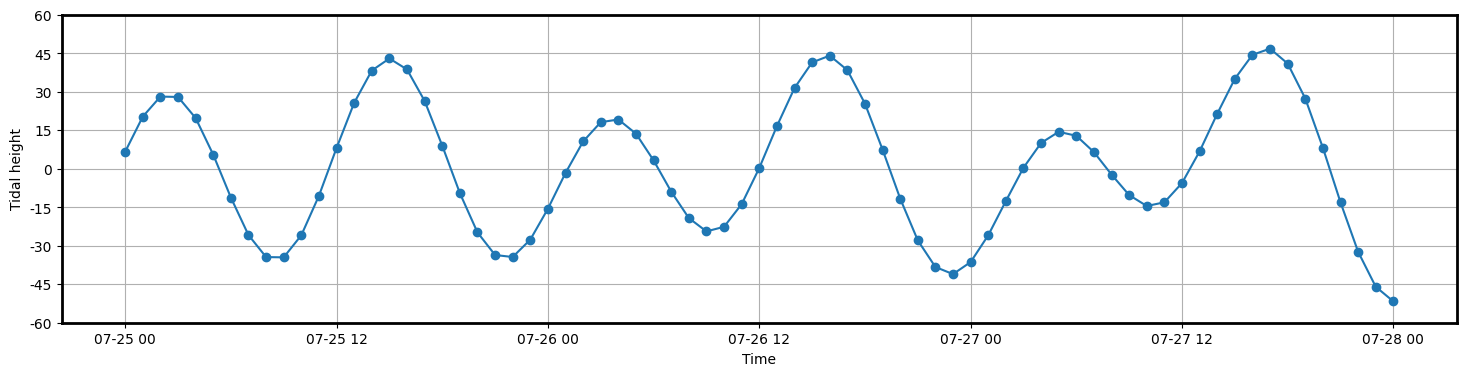

In [105]:
plot_tide(tide_level, dtime)

In [15]:
# Create current model object
def get_current_model(model_name, model_directory, model_format, compressed=False):
    return model(model_directory, format=model_format, compressed=compressed).current(model_name)

tpxo_curr_model = get_current_model(tpxo_model_name, tpxo_model_directory, tpxo_model_format, tpxo_compressed)

In [20]:
print(tpxo_curr_model.model_file)

{'u': [PosixPath('/home/bioer/python/tide/data_src/TPXO9_atlas_v5/u_q1_tpxo9_atlas_30_v5.nc'), PosixPath('/home/bioer/python/tide/data_src/TPXO9_atlas_v5/u_o1_tpxo9_atlas_30_v5.nc'), PosixPath('/home/bioer/python/tide/data_src/TPXO9_atlas_v5/u_p1_tpxo9_atlas_30_v5.nc'), PosixPath('/home/bioer/python/tide/data_src/TPXO9_atlas_v5/u_k1_tpxo9_atlas_30_v5.nc'), PosixPath('/home/bioer/python/tide/data_src/TPXO9_atlas_v5/u_n2_tpxo9_atlas_30_v5.nc'), PosixPath('/home/bioer/python/tide/data_src/TPXO9_atlas_v5/u_m2_tpxo9_atlas_30_v5.nc'), PosixPath('/home/bioer/python/tide/data_src/TPXO9_atlas_v5/u_s1_tpxo9_atlas_30_v5.nc'), PosixPath('/home/bioer/python/tide/data_src/TPXO9_atlas_v5/u_s2_tpxo9_atlas_30_v5.nc'), PosixPath('/home/bioer/python/tide/data_src/TPXO9_atlas_v5/u_k2_tpxo9_atlas_30_v5.nc'), PosixPath('/home/bioer/python/tide/data_src/TPXO9_atlas_v5/u_m4_tpxo9_atlas_30_v5.nc'), PosixPath('/home/bioer/python/tide/data_src/TPXO9_atlas_v5/u_ms4_tpxo9_atlas_30_v5.nc'), PosixPath('/home/bioer/p

In [18]:
print(lon, lat)
print(np.atleast_1d(lon), np.atleast_1d(lat))

122.26672 23.76175
[122.26672] [23.76175]


In [81]:
# Load and interpolate tidal current constants
def get_current_constants(lon, lat, current_model, model_name, TYPE):
    if 'atlas' in model_name:
        amp,ph,D,c = ATLAS.extract_constants(
            np.atleast_1d(lon), np.atleast_1d(lat),
            current_model.grid_file,
            current_model.model_file[TYPE], type=TYPE, method='spline',
            scale=current_model.scale, compressed=current_model.compressed)
                
    return amp, ph, D, c

In [ ]:
tpxo_u_amp, tpxo_u_ph, tpxo_u_D, tpxo_u_c = get_current_constants(lon, lat, tpxo_curr_model, tpxo_model_name, "u")


In [119]:
print(tpxo_u_amp)
print(tpxo_u_ph)
print(tpxo_u_amp.shape)
print(tpxo_u_ph.shape)
print(tpxo_u_D)
print(tpxo_u_c)

[[9.497873400927286 46.81641131373324 16.44679218374848 58.00365638385176
  6.710343381987292 40.980488366118536 1.7015621871261966
  11.546055716338426 3.70831987625335 0.27772519012342267
  0.12878326059276918 0.024780699943569205 1.152981385714734
  1.3117328841015237 1.1052506814828684]]
[[250.54912138094292 286.7758163612869 304.24214344647817
  325.33106626366083 167.13609502804601 188.94231087885615
  185.24888608517173 215.09533743726675 193.77544835820555
  144.86844889975384 209.81629788814223 46.92476222072702
  117.40443583205099 74.65462332639969 207.75599864576455]]
(1, 15)
(1, 15)
[2997.0543274819684]
['q1', 'o1', 'p1', 'k1', 'n2', 'm2', 's1', 's2', 'k2', 'm4', 'ms4', 'mn4', '2n2', 'mf', 'mm']


In [57]:
tmp_u_amp, tmp_u_ph, tmp_u_D, tmp_u_c = get_current_constants(glon.ravel(), glat.ravel(), tpxo_curr_model, tpxo_model_name, "u")
print(tmp_u_amp)
print(tmp_u_ph)
print(tmp_u_amp.shape)
print(tmp_u_ph.shape)

[[29.87793592583252 176.97845047826854 69.60767712309135
  239.71179922230615 41.872174185060096 208.27947996303246
  8.600505578994499 74.98603505588405 24.26174603220531
  0.7001953943327897 0.3986530980323839 0.18993662813351392
  7.688600037832839 0.15383425952420965 0.3843170312869365]
 [20.795715572519335 126.5525762849627 46.48972260101929
  168.66051805389662 28.748568602337368 139.506401856005
  5.740380923537047 49.460290914027254 15.529767578820815
  0.3488864106976775 0.2258754755525293 0.13336587513128792
  5.215596498307579 0.3490259711381857 0.35702611630738423]
 [27.298128336008663 163.61973175547746 59.77145548106793
  216.06103365076513 38.29709148568586 184.58182096215594
  7.311897144861199 67.21044267151524 20.582962497021715
  0.5520686407378956 0.3312126654546914 0.1733812548344826
  6.664008778429934 0.31219768378214946 0.4696677422056083]
 [20.437307169504393 120.40808577983273 44.84452033189311
  159.96815294194764 28.919144717320673 136.54030972900807
  5.394

In [94]:
def get_current(ilon, ilat, tide_time, current_model, model_name):
    DELTAT = np.zeros_like(tide_time)
    timelen = len(tide_time)
    lon = ilon.ravel()
    lat = ilat.ravel()
    nx = ilon.shape[1]
    ny = ilon.shape[0] #shape of ilon, ilat should be the same!
    tide = {}

    for TYPE in ['u', 'v']:
        amp, ph, D, c = get_current_constants(lon, lat, current_model, model_name, TYPE)
        # calculate complex phase in radians for Euler's
        cph = -1j * ph * np.pi / 180.0
        # calculate constituent oscillation
        hc = amp * np.exp(cph)
        tide[TYPE] = np.ma.zeros((ny, nx, timelen))

        for hour in range(timelen):
            # predict tidal elevations at time and infer minor corrections
            TIDE = map(tide_time[hour], hc, c, deltat=DELTAT[hour], corrections=current_model.format)
            MINOR = infer_minor(tide_time[hour], hc, c, deltat=DELTAT[hour], corrections=current_model.format)
            # add major and minor components and reform grid
            # Reshape TIDE and MINOR to have the shape (ny, nx)
            tide[TYPE][:,:,hour] = np.reshape((TIDE+MINOR),(ny,nx))
               
    return tide

In [95]:
gtide = get_current(glon, glat, tide_time, tpxo_curr_model, tpxo_model_name)

30 30


/home/bioer/.pyenv/versions/3.11.3/envs/py311/lib/python3.11/site-packages/pyTMD-2.0.6.dev8+gb8f2a2a-py3.11.egg/pyTMD/io/ATLAS.py:333: RuntimeWarning: divide by zero encountered in divide
  ampl.data[:,i] = np.abs(hci.data)/unit_conv


In [115]:
# Set the time index (0 to 23)
t = 0
nx = glon.shape[1]
ny = glon.shape[0] #shape of glon, glat should be the same!

# Reshape u and v to 2D
u0 = gtide['u'][:,:,t] #.reshape(ny, nx)
v0 = gtide['v'][:,:,t] #.reshape(ny, nx)

# Create a grid of indices for subsetting
# ny, nx = np.shape(lon)
Y, X = np.meshgrid(np.arange(ny), np.arange(nx))

# Calculate magnitude of the current
magnitude = np.sqrt(u0**2 + v0**2)

# Normalize the arrows to create a uniform arrow size across the plot
u = u0/magnitude
v = v0/magnitude

print(magnitude)
print(u)
print(v)

n = 1
mask = (X % n == 0) & (Y % n == 0)

x = glon[mask]
y = glat[mask]
u = u[mask]
v = v[mask]
mag = magnitude[mask]*0.01

[[92.94695555065064 97.98192380258007 120.35745089529169
  87.32807039729263 58.26659912074527 58.4358038630788 40.04980597874614
  34.17887423315119 46.42555810141641 48.8709641497256 34.92145674167155
  22.051035212717064 25.47234494426521 38.00234770006307
  41.132295272629804 12.327076617709427 40.055900595361116
  22.61761331816088 17.067034816219262 19.285358261531627
  21.30873736351233 23.761109849221466 26.2832083529931
  29.372775723184954 32.622665309525985 36.08087348276103
  39.6512489077964 44.71526993527149 49.929279834415496 54.26160326791892]
 [143.61885943928633 168.61681797403608 258.24528795100366
  484.9643978628747 404.1783594604195 456.39864356913984
  143.78667185772537 62.701176340803066 83.72369331479271
  58.19728040069211 23.695539337547807 24.924023817695588
  44.501385184010786 82.1188371881899 94.90792440512972 85.96520242373424
  48.11117847933 58.236031877750605 31.18167235721334 26.938963829437164
  24.48104938934939 26.039997745482278 28.4559162261730

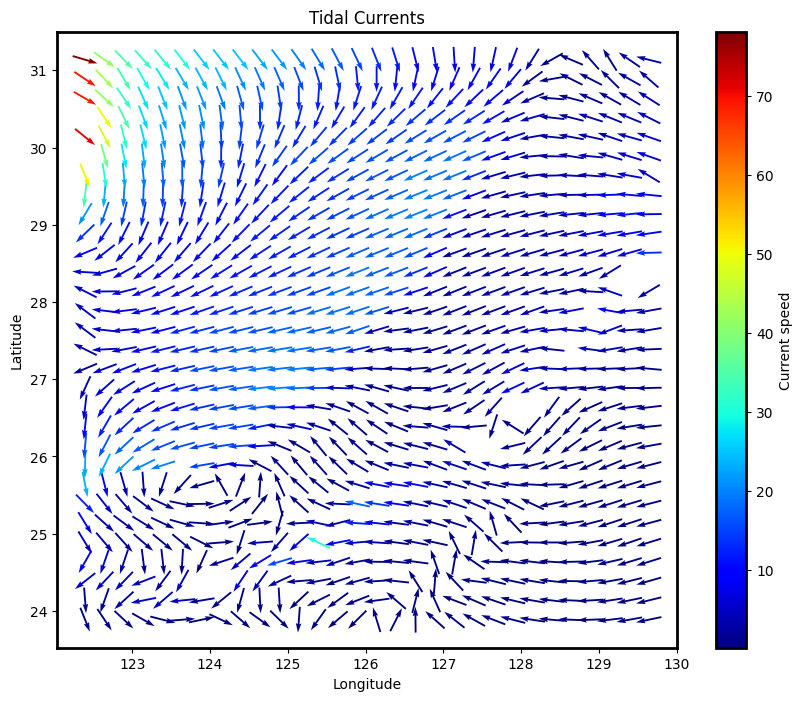

In [118]:
# Calculate magnitude of the current
# Create a figure and plot
fig, ax = plt.subplots(figsize=(10, 8))

# Plotting, note the "angles" and "scale" parameters
plt.colorbar(ax.quiver(x, y, u, v, mag, 
                       angles='xy', scale_units='xy', 
                       scale=3, pivot='middle', width=0.003, cmap='jet'), 
             ax=ax, label='Current speed')

ax.set_title('Tidal Currents')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')


plt.show()